# Chemotherapy Resistant Dataset Exploration
For exploration of chemotherapy resistance samples, this Jupyter Notebook provides a playground for analyzing and visualizing the data.

In [19]:
import os
import numpy as np
import pandas as pd
import ast
import glob
from PIL import Image

Directory/Variable Setup

In [20]:
BIOP, SUSP  = "biop",  "susp"
RES, SEN    = "res",   "sen"
FILES, DATA = "files", "data"
DIR         = "data_dir"

chemo_res = {}
chemo_res[BIOP] = {DIR: os.path.join('data', 'chemo_res_biop')}
chemo_res[SUSP] = {DIR: os.path.join('data', 'chemo_res_susp')}

for DATASET in chemo_res.values():
    DATASET[RES] = {FILES: glob.glob(os.path.join(DATASET[DIR], 'Resistant', '*.png')),
                    DATA: None}
    DATASET[SEN] = {FILES: glob.glob(os.path.join(DATASET[DIR], 'Sensitive', '*.png')),
                    DATA: None}
    del DATASET[DIR]

Biopsied Data Format
|   | Biop/Susp - Chemo_X.Y_Z.png | Susp - ChemoAll_X_Y_Z.png |
|---|-----------------------------|---------------------------|
| X | Patient Number              | Patient Number            |
| Y | Lesion Number               | Lesion Number             |
| Z | Capture Number              | Capture Number            |


In [21]:
def split_chemo_filename(filename):
    _, patient_lesion, capture = os.path.basename(filename).split('_')
    patient_num, lesion_num = patient_lesion.split('.')
    capture_num, _ = capture.split('.')
    return patient_num, lesion_num, capture_num

def split_chemo_all_filename(filename):
    _, patient_num, lesion_num, capture = os.path.basename(filename).split('_')
    capture_num, _ = capture.split('.')
    return patient_num, lesion_num, capture_num

def split_filename(filename):
    if "ChemoAll" in filename:
        return split_chemo_all_filename(filename)
    return split_chemo_filename(filename)

In [22]:
for datatype, dataset in chemo_res.items():
    data = {}

    for subset in dataset.values():
        patients = []
        captures = []
        lesions = []
        images = []

        for filename in subset[FILES]:
            patient_num, lesion_num, capture_num = split_filename(filename)
            
            patients.append(patient_num)
            captures.append(capture_num)
            lesions.append(lesion_num)
            
            img = np.array(Image.open(filename), dtype=np.uint16)
            
            images.append(img)

        subset[DATA] = pd.DataFrame({'Patient Number': patients, 'Capture Number': captures, 'Lesion Number': lesions, 'Image': images})

In [23]:
# Example: Biopsied Resistant images
chemo_res[BIOP][RES][DATA].describe()

,Patient Number,Capture Number,Lesion Number,Image
count,370,370,370,370
unique,12,10,7,370
top,100,10,2,"[[[161, 125, 120], [161, 125, 120], [160, 124,..."
freq,60,37,100,1


In [24]:
# Example: Suspicious Sensitive images
chemo_res[SUSP][SEN][DATA].describe()

,Patient Number,Capture Number,Lesion Number,Image
count,648,648,648,648
unique,15,40,25,648
top,121,1,5,"[[[150, 106, 124], [148, 104, 122], [145, 101,..."
freq,136,139,113,1


### General Histogram Plots of Pixel Intensities

In [25]:
biop_res = chemo_res[BIOP][RES][DATA]
biop_sen = chemo_res[BIOP][SEN][DATA]
susp_res = chemo_res[SUSP][RES][DATA]
susp_sen = chemo_res[SUSP][SEN][DATA]

In [54]:
import matplotlib.pyplot as plt

def create_histogram(ax, images, title='Pixel Value Histogram'):
    # Flatten the images to 1D arrays
    flattened_images = [image.flatten() for image in images]

    # Concatenate the flattened arrays into a single 1D array
    all_pixels = np.concatenate(flattened_images)

    # Create a histogram on the specified axes
    ax.hist(all_pixels, bins=256, range=(0, 256), density=True, color='blue', alpha=0.7)

    # Set plot labels and title
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')
    ax.set_title(title)

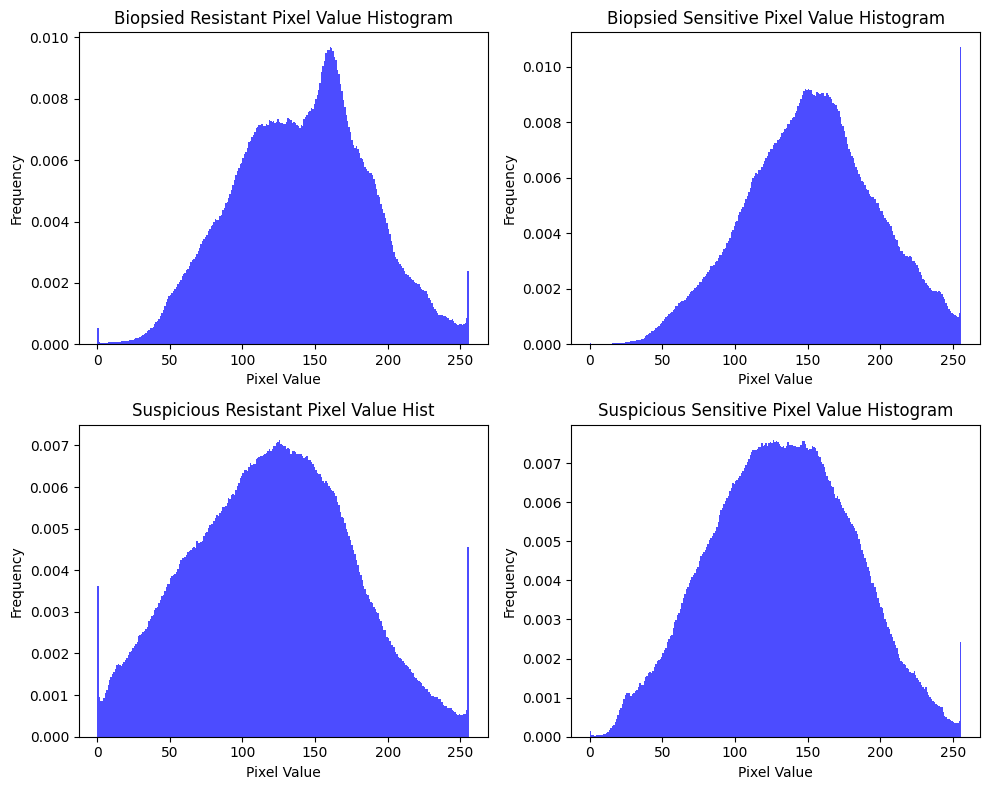

In [55]:
# Create a new set of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot on each subplot separately
create_histogram(axs[0, 0], biop_res["Image"], 'Biopsied Resistant Pixel Value Histogram')
create_histogram(axs[0, 1], biop_sen["Image"], 'Biopsied Sensitive Pixel Value Histogram')
create_histogram(axs[1, 0], susp_res["Image"], 'Suspicious Resistant Pixel Value Hist')
create_histogram(axs[1, 1], susp_sen["Image"], 'Suspicious Sensitive Pixel Value Histogram')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

### Grouping By Patient Number & Lesion Number
* In modeling, we group by the same metric for train-test-val splits

In [33]:
biop_res_mean = biop_res.groupby(['Patient Number', 'Lesion Number'])['Image'].mean()
biop_sen_mean = biop_sen.groupby(['Patient Number', 'Lesion Number'])['Image'].mean()
susp_res_mean = susp_res.groupby(['Patient Number', 'Lesion Number'])['Image'].mean()
susp_sen_mean = susp_sen.groupby(['Patient Number', 'Lesion Number'])['Image'].mean()

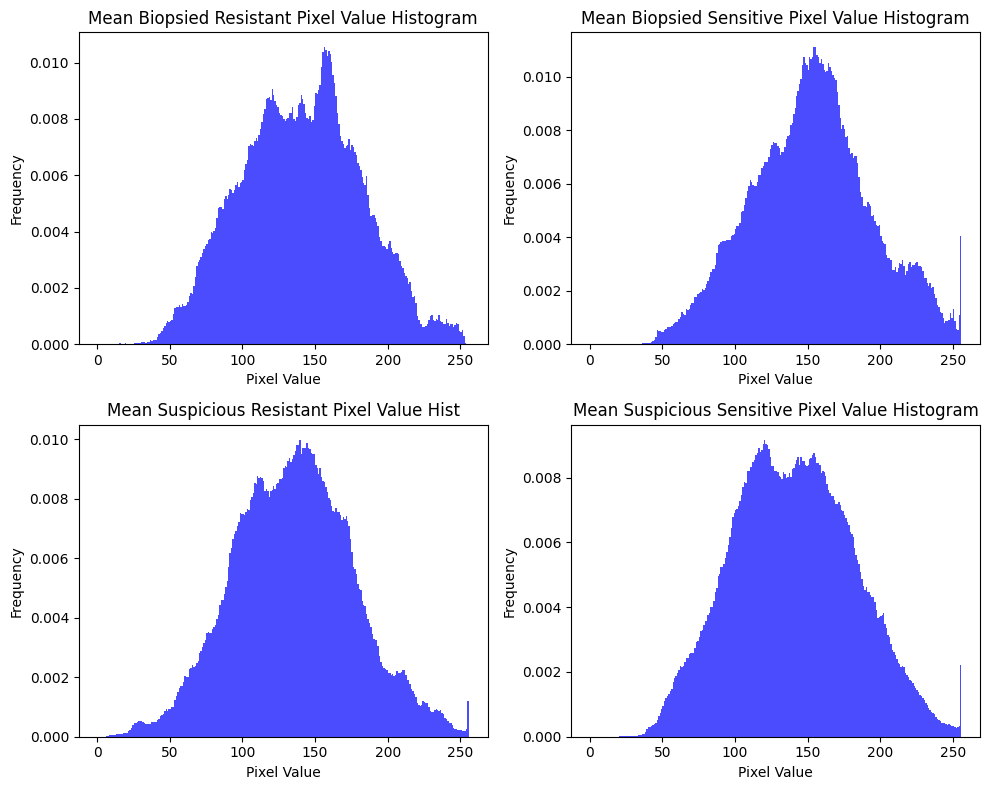

In [56]:
# Create a new set of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot on each subplot separately
create_histogram(axs[0, 0], biop_res_mean, 'Mean Biopsied Resistant Pixel Value Histogram')
create_histogram(axs[0, 1], biop_sen_mean, 'Mean Biopsied Sensitive Pixel Value Histogram')
create_histogram(axs[1, 0], susp_res_mean, 'Mean Suspicious Resistant Pixel Value Hist')
create_histogram(axs[1, 1], susp_sen_mean, 'Mean Suspicious Sensitive Pixel Value Histogram')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()